In [1]:
#importing necessary python packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

In [2]:
# Importing the dataset
dt = pd.read_excel('Gene Clinical.xlsx',index_col=0)


In [3]:
dt.shape

(517, 15154)

In [4]:
dt.head(2)

,UBE2Q2P2,SSX9,CXORF67,EFCAB8,SDR16C6P,EFCAB12,A1BG,A1CF,RBFOX1,GGACT,...,Tissue Source Site_NJ,Tissue Source Site_O1,Tissue Source Site_S2,Person Neoplasm Status_TUMOR FREE,Person Neoplasm Status_WITH TUMOR,Vial number_A,Vial number_B,Patient's Vital Status_Alive,Patient's Vital Status_Dead,Overall Survival (Months)
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,-0.4238,-0.1379,-0.1805,0.4529,-0.3317,-0.1012,-0.6977,-0.1476,-0.224,0.3832,...,0,0,0,1,0,1,0,1,0,0.00
TCGA-05-4249-01,-0.3291,-0.1379,-0.1805,-0.0869,-0.3317,-0.1661,-0.1483,-0.1371,-0.226,-0.5346,...,0,0,0,1,0,1,0,1,0,50.03


In [5]:

del dt['Patient\'s Vital Status_Dead']
del dt['Patient\'s Vital Status_Alive']

In [6]:
del dt['Column1']

In [7]:
X = dt.iloc[:,0:15150]
y = dt.iloc[:, -1].values

In [8]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [10]:
# Create a random forest Regressor
rgr = RandomForestRegressor(n_estimators=100, random_state=0)

In [11]:
# Train the Regressor
rgr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
# Print the name and importance of each feature
for feature in zip(X.columns, rgr.feature_importances_):
    print(feature)

In [13]:
#Select the best features from the regressor
sfm = SelectFromModel(rgr)

In [14]:
# Train the Regressor
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [ ]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(X.columns[feature_list_index])

In [16]:
sfm.get_support().sum()

1544

In [17]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_val = sfm.transform(X_val)
X_important_test = sfm.transform(X_test)

In [18]:
rgr_important = SVR()

# Train the new Regressor on the new dataset containing the most important features
rgr_important.fit(X_important_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
y_predval = rgr_important.predict(X_important_val)

In [20]:
#Compare The Accuracy Of Our Full Feature Regressor To Our Limited Feature Regressor
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

from sklearn.metrics import r2_score
accuracy=r2_score(y_val,y_predval)

print('R2 Score')
print(accuracy)

16.223200545470036
585.0162828167382
24.18710984836217
R2 Score
-0.07070928942051768


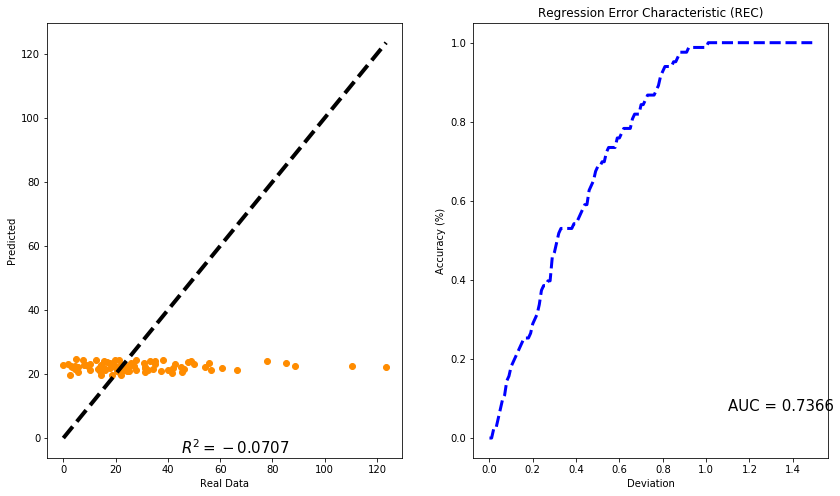

In [22]:
# Visualising the Support Vector Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(14 , 8))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.text(45, -5, r"$R^2 = %0.4f$" %RR , fontsize=15)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [23]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {  'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2],
                 'cache_size':[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100,200,300],
                 'degree':[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
                 'coef0':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.5], 
                 'epsilon': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
                 }  
regressor = SVR()
random=RandomizedSearchCV(estimator=regressor,param_distributions=param_grid,cv=3,n_iter=10)
random_result=random.fit(X_important_train,y_train)
print("Best: %f using %s" % (random_result.best_score_,random_result.best_params_))

/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/

/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/

Best: -0.034444 using {'epsilon': 0.5, 'degree': 7, 'coef0': 1.5, 'cache_size': 8, 'C': 2}


In [24]:
regressor = SVR(C=2,cache_size=8,coef0=1.5,degree=7,epsilon=0.5)

regressor.fit(X_important_train, y_train)

SVR(C=2, cache_size=8, coef0=1.5, degree=7, epsilon=0.5,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
y_predval = regressor.predict(X_important_val)

In [26]:

# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_important_val, y_val))

from sklearn.metrics import r2_score
accuracy=r2_score(y_val,y_predval)

print('R2 Score')
print(accuracy)

16.22725134016602
578.5853927705242
24.0538020439706
Variance score: -0.06
R2 Score
-0.058939337174794826


R^2 = -0.0589


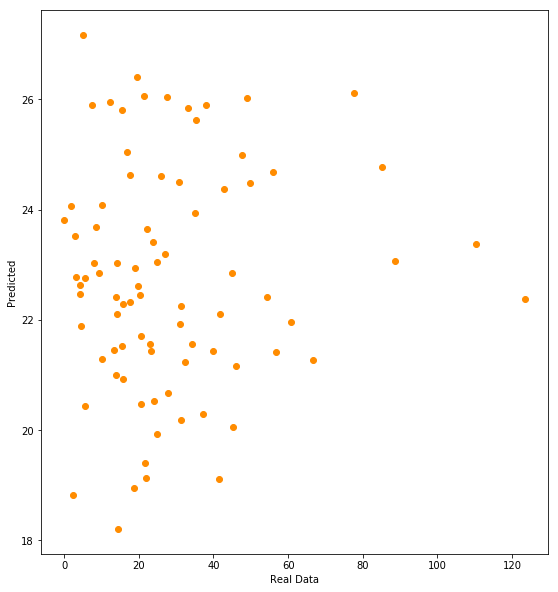

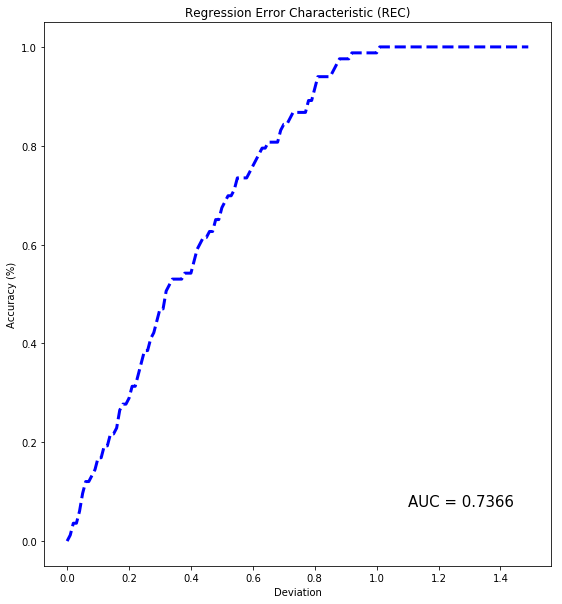

In [27]:
# Visualising the Support Vector Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [28]:
###############################################Testing Set##############################################################

# Fitting Training Set
regressor = SVR(C=2,cache_size=8,coef0=1.5,degree=7,epsilon=0.5)

regressor.fit(X_important_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_important_test)

# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, y_pred))

# Print result of MSE
print(metrics.mean_squared_error(y_test, y_pred))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_important_test, y_test))

from sklearn.metrics import r2_score
accuracy=r2_score(y_test,y_pred)

print('R2 Score')
print(accuracy)

19.390126833676888
1413.9379924978198
37.60236684701935
Variance score: -0.05
R2 Score
-0.04945589930650662


R^2 = -0.0495


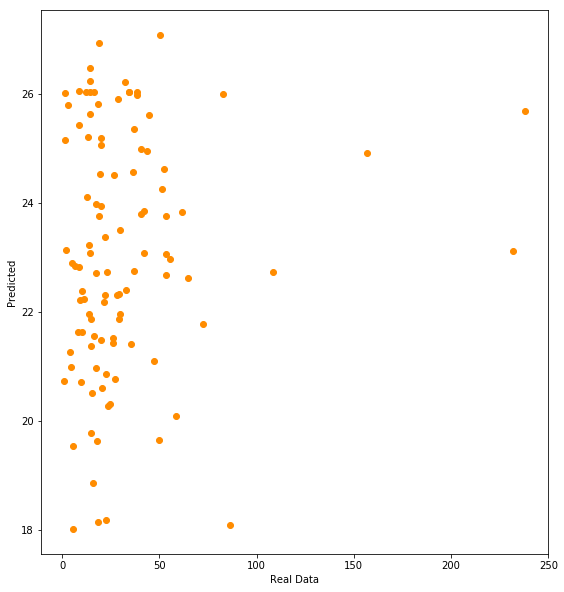

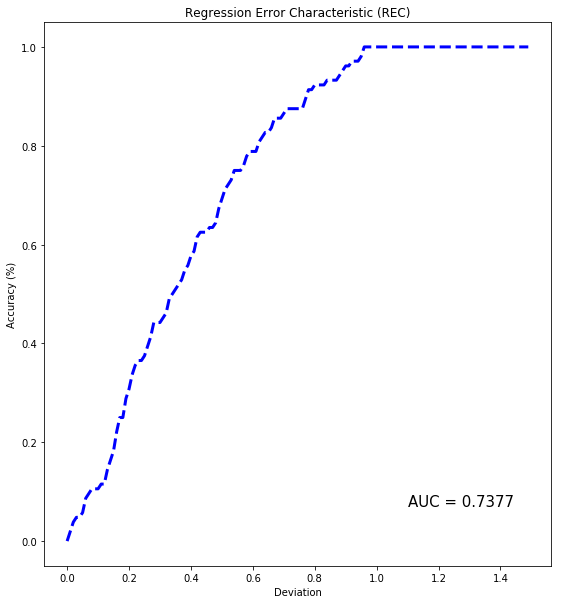

In [29]:
# Visualising the Support Vector Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_test , y_pred):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_test)):
            if np.linalg.norm(y_test[j] - y_pred[j]) / np.sqrt( np.linalg.norm(y_test[j]) **2 + np.linalg.norm(y_pred[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_test))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_test, y_pred)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_test, y_pred)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()